<a href="https://colab.research.google.com/github/TheGooseGuy/Recipe-Classification/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
import requests

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [7]:
train_data_url = "https://github.com/TheGooseGuy/Recipe-Classification/raw/main/Data/train.json"
test_data_url = "https://github.com/TheGooseGuy/Recipe-Classification/raw/main/Data/test.json"

train_data_response = requests.get(train_data_url)
test_data_response = requests.get(test_data_url)

train_data = pd.DataFrame(json.loads(train_data_response.text))
test_data = pd.DataFrame(json.loads(test_data_response.text))

# Exploratory Data Analysis (EDA)

## Data Structure

In [19]:
print("Train dataset:", train_data.shape)
print(train_data.head(20))
print("")
print("Test dataset:", test_data.shape)
print(test_data.head(20))

(39774, 3)
       id      cuisine                                        ingredients
0   10259        greek  [romaine lettuce, black olives, grape tomatoes...
1   25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2   20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3   22213       indian                [water, vegetable oil, wheat, salt]
4   13162       indian  [black pepper, shallots, cornflour, cayenne pe...
5    6602     jamaican  [plain flour, sugar, butter, eggs, fresh ginge...
6   42779      spanish  [olive oil, salt, medium shrimp, pepper, garli...
7    3735      italian  [sugar, pistachio nuts, white almond bark, flo...
8   16903      mexican  [olive oil, purple onion, fresh pineapple, por...
9   12734      italian  [chopped tomatoes, fresh basil, garlic, extra-...
10   5875      italian  [pimentos, sweet pepper, dried oregano, olive ...
11  45887      chinese  [low sodium soy sauce, fresh ginger, dry musta...
12   2698      italian  [It

In [21]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None



In [23]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB
None


Train dataset has 3 columns, "id", "cuisine", and "ingredients". It has 39774 rows.  
Test dataset has 2 colums, "id" and "ingredients". It has 9944 rows. We have to predict the "cuisine" column in this dataset.

## Analyze Ingredient Frequency and Variety

In [31]:
from collections import Counter

# Flatten the list of ingredients
all_ingredients = [ingredient for sublist in train_data['ingredients'] for ingredient in sublist]
ingredient_counts = Counter(all_ingredients)

# Top 20 most common ingredients
print("Top 10 most common ingredients:")
for i in ingredient_counts.most_common(20):
    print(f"{i[0]}: {i[1]}")

print("")

# Bottom 10 least common ingredients
print("Bottom 10 least common ingredients:")
for i in ingredient_counts.most_common()[-10:]:
    print(f"{i[0]}: {i[1]}")

Top 10 most common ingredients:
salt: 18049
onions: 7972
olive oil: 7972
water: 7457
garlic: 7380
sugar: 6434
garlic cloves: 6237
butter: 4848
ground black pepper: 4785
all-purpose flour: 4632
pepper: 4438
vegetable oil: 4385
eggs: 3388
soy sauce: 3296
kosher salt: 3113
green onions: 3078
tomatoes: 3058
large eggs: 2948
carrots: 2814
unsalted butter: 2782

Bottom 10 least common ingredients:
Oscar Mayer Cotto Salami: 1
Challenge Butter: 1
orange glaze: 1
cholesterol free egg substitute: 1
ciabatta loaf: 1
Lipton® Iced Tea Brew Family Size Tea Bags: 1
Hidden Valley® Greek Yogurt Original Ranch® Dip Mix: 1
lop chong: 1
tomato garlic pasta sauce: 1
crushed cheese crackers: 1


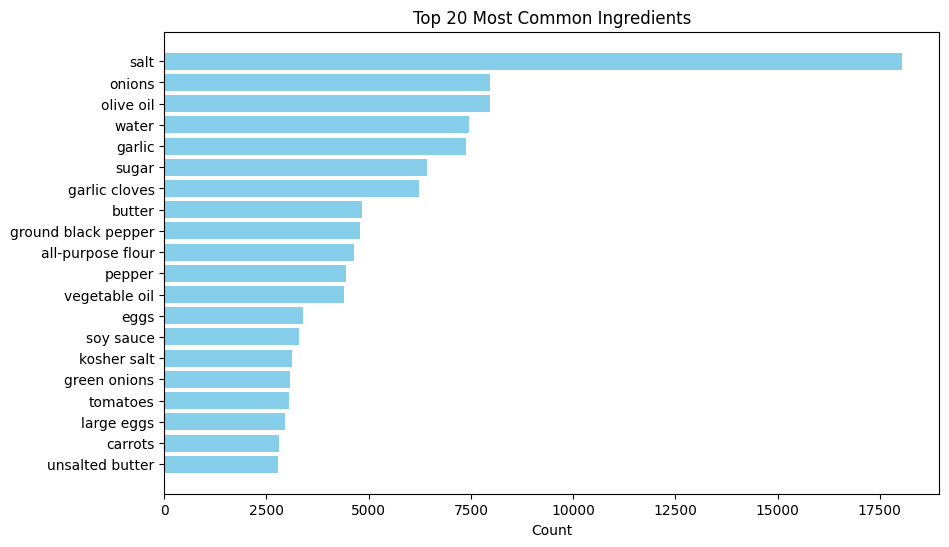

In [30]:
# Bar plot for top ingredients
top_ingredients = ingredient_counts.most_common(20)
ingredients, counts = zip(*top_ingredients)

plt.figure(figsize=(10, 6))
plt.barh(ingredients, counts, color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Common Ingredients')
plt.gca().invert_yaxis()
plt.show()


## Missing or Unusual Data

In [34]:
print(train_data.isnull().sum())

print("")

print(test_data.isnull().sum())

id             0
cuisine        0
ingredients    0
dtype: int64

id             0
ingredients    0
dtype: int64


Both train dataset and test dataset has no missing value.

In [37]:
# Find rows with empty ingredient lists
empty_ingredients = train_data[train_data['ingredients'].apply(len) == 0]
print(f"Number of recipes with no ingredients: {len(empty_ingredients)}")

Number of recipes with no ingredients: 0


## Class Distribution

In [40]:
cuisine_counts = train_data['cuisine'].value_counts()
print(cuisine_counts)

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64


The classes are imbalanced, however, whether use resampling or not should be decided by model choice as different model has different sensitivity to class imbalance.

# Preprocessing

In [46]:
train_data['is_train'] = 1
test_data['is_train'] = 0

# Combine train and test data for preprocessing
combined_data = pd.concat([train_data, test_data], ignore_index=True)

## Text Cleaning

In [48]:
nltk.download('stopwords')

nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [49]:
# Initialize tools for stemming
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Example cleaning function
def clean_ingredients(ingredients):
    cleaned = []
    for ingredient in ingredients:
        # Lowercase
        ingredient = ingredient.lower()
        # Remove special characters
        ingredient = re.sub(r'[^a-z\s]', '', ingredient)
        # Tokenize and optionally remove stopwords
        tokens = word_tokenize(ingredient)
        tokens = [word for word in tokens if word not in stop_words]
        # Stem words
        tokens = [stemmer.stem(word) for word in tokens]
        cleaned.append(" ".join(tokens))
    return cleaned

combined_data['cleaned_ingredients'] = combined_data['ingredients'].apply(clean_ingredients)

## Convert Ingredients to Text Data

In [50]:
# Combine ingredients into a single string for each row
combined_data['ingredients_text'] = combined_data['cleaned_ingredients'].apply(lambda x: ' '.join(x))

## Feature Engineering

In [51]:
combined_data['ingredient_count'] = combined_data['ingredients'].apply(len)

## Summary

In [53]:
print(combined_data.head(5))

      id      cuisine                                        ingredients  \
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3  22213       indian                [water, vegetable oil, wheat, salt]   
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...   

   is_train                                cleaned_ingredients  \
0         1  [romain lettuc, black oliv, grape tomato, garl...   
1         1  [plain flour, ground pepper, salt, tomato, gro...   
2         1  [egg, pepper, salt, mayonais, cook oil, green ...   
3         1                    [water, veget oil, wheat, salt]   
4         1  [black pepper, shallot, cornflour, cayenn pepp...   

                                    ingredients_text  ingredient_count  
0  romain lettuc black oliv grape tomato garlic p...                 9  


In [56]:
train_data = combined_data[combined_data['is_train'] == 1]
test_data = combined_data[combined_data['is_train'] == 0]

# Convert Text to Vectors

Two options:
1. TF-IDF,
2. Word Embeddings: Use pre-trained embeddings (e.g., Word2Vec, GloVe).

## TF-IDF

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
tfidf = TfidfVectorizer(
    max_features=1000,  # Limit to top 1000 terms
    ngram_range=(1, 1),  # Use unigrams only
    min_df=5,         # Ignore terms appearing in less than 5 documents
    max_df=0.8           # Ignore terms appearing in more than 80% of documents
)

In [60]:
# Fit the vectorizer to the text data
X_tfidf = tfidf.fit_transform(train_data['ingredients_text'])

# Convert the result to a DataFrame for interpretability
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [61]:
print(tfidf_df.head())


   achiot  activ  adobo  agav  age  ale  alfredo  allpurpos  allspic  almond  \
0     0.0    0.0    0.0   0.0  0.0  0.0      0.0        0.0      0.0     0.0   
1     0.0    0.0    0.0   0.0  0.0  0.0      0.0        0.0      0.0     0.0   
2     0.0    0.0    0.0   0.0  0.0  0.0      0.0        0.0      0.0     0.0   
3     0.0    0.0    0.0   0.0  0.0  0.0      0.0        0.0      0.0     0.0   
4     0.0    0.0    0.0   0.0  0.0  0.0      0.0        0.0      0.0     0.0   

   ...  yeast    yellow  yoghurt    yogurt  yolk  yukon  zest  zesti  ziti  \
0  ...    0.0  0.000000      0.0  0.000000   0.0    0.0   0.0    0.0   0.0   
1  ...    0.0  0.278648      0.0  0.000000   0.0    0.0   0.0    0.0   0.0   
2  ...    0.0  0.275939      0.0  0.000000   0.0    0.0   0.0    0.0   0.0   
3  ...    0.0  0.000000      0.0  0.000000   0.0    0.0   0.0    0.0   0.0   
4  ...    0.0  0.000000      0.0  0.195325   0.0    0.0   0.0    0.0   0.0   

   zucchini  
0       0.0  
1       0.0  
2       

In [63]:
# Combine TF-IDF features with other engineered features
X = pd.concat([tfidf_df, train_data[['ingredient_count']].reset_index(drop=True)], axis=1)